In [1]:
# Import packages

## Mosdef
import mbuild
import foyer 

# Misc
import numpy as np
import matplotlib.pyplot as plt

# Molecular Visualization
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/mdtraj/formats/__init__.py:13: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from mdtraj.formats.trr import TRRTrajectoryFile
/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/foyer/forcefield.py:33: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points, resource_filename
/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/pkg_resources/__init__.py:2825: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/lark/

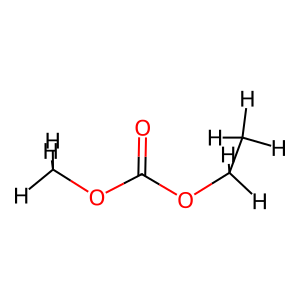

In [4]:
system_smiles = "CCOC(=O)OC"
## Vizualize the molecule using rdkit and the smiles string
molecule = Chem.MolFromSmiles(system_smiles)

## add hydrogens
molecule = Chem.AddHs(molecule)
AllChem.EmbedMolecule(molecule) ## atoms positioned randomly every run

## Draw the molecule
Draw.MolToImage(molecule)

In [5]:
#Define inputs for mbuild and foyer

# Define SMILES string of the molecule of interest: EC for example
system_smiles = 'CCOC(=O)OC'  

# Box size (nm) 
box_size = 2.23

# Define the number of molecules in the system 
n_molecules = 1 

# OPLS-AA forcefield. Can be changed by available forcefileds in mbuild
forcefield_name = 'oplsaa' 

# Name of the data file to be created
system_name = 'EMC_1molecule' 



In [6]:

# Use mbuild to create the unparametrized molecule using the smiles string
system_unparad = mbuild.load(system_smiles, smiles=True)

# assign name to unparametrized molecule
system_unparad.name = system_name

# Define the cubic box
box = mbuild.Box(3*[box_size])

# Fill the box with the molecule of interest using density or number of molecules
filled_box = mbuild.fill_box(compound=system_unparad, n_compounds=1, box=box, overlap=0.2)

print(type(filled_box))

print(filled_box)

print(vars(filled_box))

filled_box.visualize()

<class 'mbuild.compound.Compound'>
<Compound 15 particles, 14 bonds, System box: Box: Lx=2.230000, Ly=2.230000, Lz=2.230000, xy=0.000000, xz=0.000000, yz=0.000000, , id: 139869878223360>
{'name': 'Compound', '_pos': array([0., 0., 0.]), 'parent': None, 'children': [<EMC_1molecule 15 particles, 14 bonds, non-periodic, id: 139869872556752>], 'labels': OrderedDict({'EMC_1molecule': [<EMC_1molecule 15 particles, 14 bonds, non-periodic, id: 139869872556752>], 'EMC_1molecule[0]': <EMC_1molecule 15 particles, 14 bonds, non-periodic, id: 139869872556752>}), 'referrers': set(), 'bond_graph': <mbuild.bond_graph.BondGraph object at 0x7f35fe199fd0>, 'port_particle': False, '_rigid_id': None, '_contains_rigid': False, '_check_if_contains_rigid_bodies': False, '_element': None, '_box': Box: Lx=2.230000, Ly=2.230000, Lz=2.230000, xy=0.000000, xz=0.000000, yz=0.000000, , '_periodicity': (False, False, False), '_charge': None, '_mass': None}


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [7]:
# apply the forcefield to the system to create a parameterized system
ff = foyer.Forcefield(name=forcefield_name)
filled_box_param = filled_box.to_parmed(infer_residues=True) # Parmed structure
filled_box_parametrized = ff.apply(filled_box_param) # ff applied


## Pass the parametrized system to a Lammps data file using mbuild
mbuild.formats.lammpsdata.write_lammpsdata(
   filled_box_parametrized, 
   str(system_name)+".data",
   atom_style="full",
   unit_style="real",
   use_rb_torsions=True,
)

/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/foyer/validator.py:165: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart definition(s)", ValidationWarning)


No urey bradley terms detected, will use angle_style harmonic
RB Torsions detected, will use dihedral_style opls


/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/foyer/forcefield.py:349: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 13, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)
/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/foyer/forcefield.py:926: UserWarning: Parametrized structure has non-zero charge.Structure's total charge: -0.08000000000000002
  warnings.warn(
/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/mbuild/formats/lammpsdata.py:212: UserWarning: Explicit box bounds (i.e., mins and maxs) were not provided. Box bounds are assumed to be min = 0 and max = length in each direction. This may not produce a system with the expected spatial location and may cause non-periodic systems to fail. Bounds can be defined explicitly by passing the them to the write

In [2]:
# import foyer
# import inspect
# inspect.getfile(foyer)

/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/mdtraj/formats/__init__.py:13: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from mdtraj.formats.trr import TRRTrajectoryFile


'/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/foyer/__init__.py'

Usually we are interested in systems with a significantly larger amount of molecules. Lets define a function to calculate the amount of molecules that are required to have a liquid density of the molecule of interest.

In [12]:
## Define function to calculate the number of molecules required for a simulation box of desired density

def molecules_required_for_simulation_box(dens,box_side,smiles_string,verbose=False):
    """
    Calculate the number of molecules required for a simulation box of desired density.
    Args:
    dens (float): The desired density of the simulation box in g/cm^3.
    box_side (float): The length of one side of the simulation box in Angstrom.
    smiles_string (str): The SMILES string of the molecule of interest.
    
    Returns:
    float: The number of molecules required.

    """

    # Ask user for desired density and molar mass of molecule of interest
    #dens = float(input('Insert density of simulation box (g/cm^3): '))

    ## Calculate the mass of the molecule
    mol = Chem.MolFromSmiles(smiles_string)
    mm = Chem.rdMolDescriptors.CalcExactMolWt(mol) # g/mol

    # Determine volume of the simulation box and convert to meters
    vol_a = box_side**3 ##A^3

    ## 1 A = 10^-1 nm
    arm = 10**(-10) #m 
    vol_m = vol_a* arm**3 ##m^3

    # Use inputs to determine molarity (mol/cm3) 
    molarity_cm = dens/mm # mol/cm3
    molarity_m = molarity_cm*(100**3)  #mol/m3

    # Define avogadro's number
    Na = 6.022*(10**23) ## particle/mol

    # Determine the number of molecules and print results
    # Maybe floor the value instead of round??
    # num = round(molarity_m*vol_m*Na)
    import math
    num = math.floor(molarity_m*vol_m*Na)

    # Calculate the total number of atoms
    mol = Chem.AddHs(mol)
    num_atoms = mol.GetNumAtoms()

    if verbose:
        print('The required number of molecules is:', num)
        print('The required number of atoms is:', num*num_atoms)

    return num


# Define the density, size of the simulation box, and the SMILES molecule of interest
smiles_string = 'CCOC(=O)OC' # EMC
dens = 0.97 # g/cm^3
box_side = 26 # Angstrom


# Call the function and print the result
tou_molecules = molecules_required_for_simulation_box(dens,box_side,smiles_string,verbose=True)

The required number of molecules is: 98
The required number of atoms is: 1470


In [13]:
## Calculate the mass of the molecule
mol = Chem.MolFromSmiles(smiles_string)
mm = Chem.rdMolDescriptors.CalcExactMolWt(mol) # g/mol
mol = Chem.AddHs(mol)
num_atoms = mol.GetNumAtoms()

print('The mass of the molecule is:', mm, 'g/mol')
print('The number of atoms in the molecule is:', num_atoms)


The mass of the molecule is: 104.047344116 g/mol
The number of atoms in the molecule is: 15


## Now we can generate the LAMMPS data file using the calculated  number of molecules


In [14]:
#Define inputs for mbuild and foyer

# Define SMILES string of the molecule of interest: Touluene for example
system_smiles = 'CCOC(=O)OC'  

# Box size (nm) 
box_size = 2.6

# Define the number of molecules in the system 
n_molecules = tou_molecules 
#print(n_molecules)

# OPLS-AA forcefield. Can be changed by available forcefileds in mbuild
forcefield_name = 'oplsaa' 

# Name of the data file to be created
system_name = 'EMC_density.97'

###############Generate the data file####################

# Use mbuild to create the unparametrized molecule using the smiles string
system_unparad = mbuild.load(system_smiles, smiles=True)

# assign name to unparametrized molecule
system_unparad.name = system_name

# Define the cubic box
box = mbuild.Box(3*[box_size])

# Fill the box with the molecule of interest using density or number of molecules
filled_box = mbuild.fill_box(compound=system_unparad, n_compounds=n_molecules, box=box, overlap=0.2)


## apply the forcefield to the system to create a parameterized system
ff = foyer.Forcefield(name=forcefield_name)
filled_box_param = filled_box.to_parmed(infer_residues=True) # Parmed structure
filled_box_parametrized = ff.apply(filled_box_param) # ff applied


## Pass the parametrized system to a Lammps data file using mbuild
mbuild.formats.lammpsdata.write_lammpsdata(
   filled_box_parametrized, 
   str(system_name)+".data",
   atom_style="full",
   unit_style="real",
   use_rb_torsions=True,
)



/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/foyer/forcefield.py:349: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 1274, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)
/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/foyer/forcefield.py:926: UserWarning: Parametrized structure has non-zero charge.Structure's total charge: -7.840000000000002
  warnings.warn(


No urey bradley terms detected, will use angle_style harmonic
RB Torsions detected, will use dihedral_style opls


/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/mbuild/formats/lammpsdata.py:1143: UserWarning: No mass or defined atomtype for atom: <Atom C [0]; In EMC_density.97 0>. Using atom mass of 12.01078
  warn(
/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/mbuild/formats/lammpsdata.py:1143: UserWarning: No mass or defined atomtype for atom: <Atom C [1]; In EMC_density.97 0>. Using atom mass of 12.01078
  warn(
/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/mbuild/formats/lammpsdata.py:1143: UserWarning: No mass or defined atomtype for atom: <Atom O [2]; In EMC_density.97 0>. Using atom mass of 15.99943
  warn(
/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/mbuild/formats/lammpsdata.py:1143: UserWarning: No mass or defined atomtype for atom: <Atom C [3]; In EMC_density.97 0>. Using atom mass of 12.01078
  warn(
/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/site-packages/mbuild/formats/lammpsdata.py:114

Open the "min_npt_equil.data" and change the name of the data file. Pair, bond, angle, dihedrals styles are define according to those specified in the data file. You can change any simulation parameters to your best interest. 


This file will first run a minimization of the system and then it will run a 500 ps NPT simulation at 298 K.

In [6]:
## Get the density from the log file
# pip install lammps_logfile
import lammps_logfile as llog

log_name = 'EMC_npt.log' ## Change the path as per your directory
log_file = llog.File(log_name)

#print keywords
print(log_file.get_keywords())

/home/aman/miniforge3/envs/test_mosdef/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=122080) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


FileNotFoundError: [Errno 2] No such file or directory: 'EMC_npt.log'

In [ ]:
## Get the density and time 
density = log_file.get('Density')
time = log_file.get('Time') /1000 # ps

# Calculate average density using last 30% of the data
average_density = np.mean(density[int(len(density)*0.7):])
print(f'The average density is: {average_density:.3f} g/cm^3')


# Calculate error % in the density
error = np.abs((average_density-dens)/dens)*100
print(f'The error in the density is: {error:.3f}%')

In [ ]:
## Plot the density vs time
plt.plot(time,density)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/cm^3)')
plt.title('Density vs Time')
plt.show()


### Increasing the simulatiopn time will equilibrate the system better and reduce the error.

# Challenges and prizes

Generate a Lammps data file for liquid systems of the molecules presented bellow and equilibrate their volume for 20 ns. Calculate the average density and error of your simulations and post your resulst on the comments of the video. Be among the first 20 comments to get a 50% discount on your subscription for the one-day Masterclass on "Advanced Molecular Dynamics Simulations and Enhanced Sampling Techniques". 

To qualify, ensure you're subscribed to our channel, following us on X, and have notifications turned on for both accounts.

In [ ]:
## Define a list of the list of moleucles of interest and their smiles strings 
touluene = 'Cc1ccccc1'
tol_dens = 0.866 ## g/cm^3 @ 273K

acetone = 'CC(=O)C'
acetone_dens = 0.784 ## g/cm^3 @ 273K

ethyl_acetate = 'CCOC(C)=O'
ethyl_acetate_dens = 0.902 ## g/cm^3 @ 273K

dimethyl_sulfoxide = 'CS(=O)C'
dimethyl_sulfoxide_dens = 1.092 ## g/cm^3 @ 273K

dimethylformamide = 'CN(C)C=O'
dimethylformamide_dens = 0.944 ## g/cm^3 @ 273K


## Define list of molecules
molecules = [touluene, acetone, ethyl_acetate, dimethyl_sulfoxide, dimethylformamide]

## Define list of molecule names
molecule_names = ['Touluene', 'Acetone', 'Ethyl_acetate', 'Dimethyl_sulfoxide', 'Dimethylformamide']
mol_densities = [tol_dens, acetone_dens, ethyl_acetate_dens, dimethyl_sulfoxide_dens, dimethylformamide_dens]    


In [ ]:
## Visualize the molecules
#make a plot showing the molecules and their names
fig, ax = plt.subplots(1,5, figsize=(20,10))
for i in range(len(molecules)):
    mol = Chem.MolFromSmiles(molecules[i])
    img = Draw.MolToImage(mol)
    ax[i].imshow(img)
    ax[i].set_title(molecule_names[i]+'\n'+'Density: '+str(mol_densities[i])+' g/cm^3')
    ax[i].axis('off')